In [2]:
from my_tools import *
import my_xy_map as xymap
import PIL.Image as Image
import semopy
T = Tools()

this_root = ''
data_root = this_root + 'Data/'
result_root = this_root + 'Result/'

In [3]:
class build_dataframe():

    def __init__(self):

        self.this_class_arr = result_root + rf'Data_frame/Frequency/MCD/'
        # self.this_class_arr = result_root + rf'Data_frame/Frequency/Trendy_ensemble/'

        Tools().mk_dir(self.this_class_arr, force=True)
        self.dff = self.this_class_arr + 'frequency_dataframe.df'
        self.P_PET_fdir = data_root+rf'/Base_data/aridity_P_PET_dic/'
        pass

    def run(self):

        df = self.__gen_df_init(self.dff)
        df=self.foo1(df)

        df = self.add_row(df)

        df = self.add_max_trend_to_df(df)

        df = self.add_NDVI_mask(df)

        df = self.add_GLC_landcover_data_to_df(df)

        P_PET_dic = self.P_PET_ratio(self.P_PET_fdir)
        P_PET_reclass_dic = self.P_PET_reclass_2(P_PET_dic)
        df = T.add_spatial_dic_to_df(df, P_PET_reclass_dic, 'HI_class')


        # df=self.show_field(df)
        # df = self.drop_field_df(df)
        df=self.rename_dataframe_columns(df)

        T.save_df(df, self.dff)
        self.__df_to_excel(df, self.dff)

    def __gen_df_init(self, file):
        df = pd.DataFrame()
        if not os.path.isfile(file):
            T.save_df(df, file)
            return df
        else:
            df = self.__load_df(file)
            return df
            # raise Warning('{} is already existed'.format(self.dff))

    def __load_df(self, file):
        df = T.load_df(file)
        return df
        # return df_early,dff

    def __df_to_excel(self, df, dff, n=1000, random=False):
        dff = dff.split('.')[0]
        if n == None:
            df.to_excel('{}.xlsx'.format(dff))
        else:
            if random:
                df = df.sample(n=n, random_state=1)
                df.to_excel('{}.xlsx'.format(dff))
            else:
                df = df.head(n)
                df.to_excel('{}.xlsx'.format(dff))

        pass

    def foo1(self, df):

        f = result_root + rf'detrend_zscore/LAI/early_peak/MCD.npy'
        dic = {}
        outf = self.dff
        result_dic = {}
        dic = T.load_npy(f)

        pix_list = []
        change_rate_list = []
        year = []
        f_name = f.split('/')[-2]+'_'+f.split('/')[-1].split('.')[0]
        # print(f_name)

        for pix in tqdm(dic):
            time_series = dic[pix]

            y = 2002
            for val in time_series:
                pix_list.append(pix)
                change_rate_list.append(val)
                year.append(y + 1)
                y = y + 1
                if y+1>2021:
                    break
        df['pix'] = pix_list
        df[f_name] = change_rate_list
        df['year'] = year
        # T.save_df(df, outf)
        # df = df.head(1000)
        # df.to_excel(outf+'.xlsx')
        return df

    def foo2(self, df):

        f = 'zscore/daily_Y/peak/during_peak_LAI3g_zscore.npy'
        val_array = np.load(f)
        val_dic = DIC_and_TIF().spatial_arr_to_dic(val_array)

        # exit()

        pix_list = []
        for pix in tqdm(val_dic):
            pix_list.append(pix)
        df['pix'] = pix_list

        return df

    def add_row(self,df):
        r_list=[]
        for i, row in tqdm(df.iterrows(), total=len(df)):
            pix = row['pix']
            r,c=pix
            r_list.append(r)
        df['row'] = r_list
        return df

    def add_max_trend_to_df(self, df):


        fdir = data_root+rf'/Base_data/lc_trend/'
        for f in (os.listdir(fdir)):
            # print()
            if not 'max_trend' in f:
                continue
            if not f.endswith('.npy'):
                continue
            if 'p_value' in f:
                continue

            val_array = np.load(fdir + f)
            val_dic = DIC_and_TIF().spatial_arr_to_dic(val_array)
            f_name = f.split('.')[0]
            # print(f_name)
            # exit()
            val_list = []
            for i, row in tqdm(df.iterrows(), total=len(df)):

                pix = row['pix']
                if not pix in val_dic:
                    val_list.append(np.nan)
                    continue
                val = val_dic[pix]
                val = val * 20
                if val < -99:
                    val_list.append(np.nan)
                    continue
                val_list.append(val)
            df[f_name] = val_list

        return df
    def add_NDVI_mask(self,df):
        f =data_root+rf'/Base_data/NDVI_mask.tif'


        array, originX, originY, pixelWidth, pixelHeight = ToRaster().raster2array(f)
        array = np.array(array, dtype=float)
        val_dic = DIC_and_TIF().spatial_arr_to_dic(array)
        f_name = 'NDVI_MASK'
        # print(f_name)
        # exit()
        val_list = []
        for i, row in tqdm(df.iterrows(), total=len(df)):

            pix = row['pix']
            if not pix in val_dic:
                val_list.append(np.nan)
                continue
            vals = val_dic[pix]
            if vals < -99:
                val_list.append(np.nan)
                continue
            val_list.append(vals)
        df[f_name] = val_list
        return df
    def add_GLC_landcover_data_to_df(self, df):


        f = data_root+rf'/Base_data/LC_reclass2.npy'

        val_dic=T.load_npy(f)

        f_name = f.split('.')[0]
        # print(f_name)

        val_list = []
        for i, row in tqdm(df.iterrows(), total=len(df)):

            pix = row['pix']
            if not pix in val_dic:
                val_list.append(np.nan)
                continue
            vals = val_dic[pix]
            val_list.append(vals)

        df['landcover_GLC'] = val_list
        return df

    def P_PET_ratio(self, P_PET_fdir):

        fdir = P_PET_fdir
        dic = T.load_npy_dir(fdir)
        dic_long_term = {}
        for pix in dic:
            vals = dic[pix]
            vals = np.array(vals)
            vals = T.mask_999999_arr(vals, warning=False)
            vals[vals == 0] = np.nan
            if T.is_all_nan(vals):
                continue
            vals = self.drop_n_std(vals)
            long_term_vals = np.nanmean(vals)
            dic_long_term[pix] = long_term_vals
        return dic_long_term

    def drop_n_std(self, vals, n=1):
        vals = np.array(vals)
        mean = np.nanmean(vals)
        std = np.nanstd(vals)
        up = mean + n * std
        down = mean - n * std
        vals[vals > up] = np.nan
        vals[vals < down] = np.nan
        return vals

    def P_PET_reclass(self,dic):
        dic_reclass = {}
        for pix in dic:
            val = dic[pix]
            label = None
            # label = np.nan
            if val > 0.65:
                label = 'Humid'
                # label = 3
            elif val < 0.2:
                label = 'Arid'
                # label = 0
            elif val > 0.2 and val < 0.5:
                label = 'Semi Arid'
                # label = 1
            elif val > 0.5 and val < 0.65:
                label = 'Semi Humid'
                # label = 2
            dic_reclass[pix] = label
        return dic_reclass


    def P_PET_reclass_2(self,dic):
        dic_reclass = {}
        for pix in dic:
            val = dic[pix]
            label = None
            # label = np.nan
            if val > 0.65:
                label = 'Humid'
                # label = 3
            elif val < 0.2:
                label = 'Dryland'
                # label = 0
            elif val > 0.2 and val < 0.5:
                label = 'Dryland'
                # label = 1
            elif val > 0.5 and val < 0.65:
                label = 'Dryland'
                # label = 2
            dic_reclass[pix] = label
        return dic_reclass
    def show_field(self,df):
        for col in df.columns:
            print(col)
        return df

        pass

    def rename_dataframe_columns(self,df):
        df.rename(columns={'late_LPX-Bern_S2_lai': 'late_LPX_Bern_S2_lai',
                          }, inplace=True)
        return df


In [13]:
class frequency_analysis():  # Amplification and Stabilization analysis

    def __init__(self):

        # This class is used to calculate the structural equation model
        self.this_class_arr = result_root + 'Data_frame/Frequency/MCD/'
        self.this_class_tif = result_root + 'Data_frame/Frequency/MCD/tif/'

        self.dff = self.this_class_arr + 'frequency_dataframe.df'

        Tools().mkdir(self.this_class_arr, force=True)


        pass

    def run(self):

        ### 1.create frequency dataframe

        df=self.pick_greening_year_frequency_heatmap()

        ## 2. add landcover and trend, row, and some attributes such as aridity

        # call the function in the class of 'build_dataframe'
        # df = T.load_df(self.dff)
        # build_dataframe().add_row(df)
        # build_dataframe().add_NDVI_mask(df)
        # build_dataframe().add_GLC_landcover_data_to_df(df)
        # build_dataframe().add_max_trend_to_df(df)
        # P_PET_fdir = data_root + rf'/Base_data/aridity_P_PET_dic/'
        # P_PET_dic = build_dataframe().P_PET_ratio(P_PET_fdir)
        #
        # P_PET_reclass_dic = build_dataframe().P_PET_reclass_2(P_PET_dic)
        # df = T.add_spatial_dic_to_df(df, P_PET_reclass_dic, 'HI_class')


        # T.save_df(df, self.dff)
        # T.df_to_excel(df, self.dff.replace('.df', ''))


        # 3. plot frequency heatmap
        # df = T.load_df(self.dff)
        #
        # df_clean = self.clean_df(df)
        # self.frenquency_heatmap(df_clean)



        # 4. create spatial map of frequency of stabilization and amplification
        # self.spatial_frequency()


        pass

    def __load_df(self):
        dff = self.dff
        df = T.load_df(dff)

        return df, dff
        # return df_early,dff

    def clean_df(self, df):
        df = df[df['row'] < 120]
        # df = df[df['HI_class'] == 'Humid']
        # df = df[df['HI_class'] == 'Dryland']
        df = df[df['max_trend'] < 10]

        df = df[df['landcover_GLC'] != 'Crop']

        return df


    def pick_greening_year_frequency_heatmap(self): #
        # select years which is defined as stabilization, amplification years and create a dataframe

        f_early_peak_LAI = data_root + rf'/detrended_zscore_LAI/early_peak/MCD.npy'
        f_late_LAI = data_root + rf'/detrended_zscore_LAI/late/MCD.npy'
        outdir = result_root + rf'Data_frame/Frequency/MCD/'
        # outf = outdir + f'frequency_dataframe2.df'
        outf = self.dff
        T.mk_dir(outdir, force=1)
        dic_early_peak_LAI = dict(np.load(f_early_peak_LAI, allow_pickle=True, ).item())
        dic_late_LAI = dict(np.load(f_late_LAI, allow_pickle=True, ).item())
        # threshold_early_list=np.linspace(-2, 2, 21)
        #
        # threshold_late_list=np.linspace(-2, 2, 21)

        threshold_early_list = [0, 0.5, 1, 1.5, 2, 2.5, 3]

        threshold_late_list = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]

        all_result_dic={}


        for i in tqdm(range(len(threshold_early_list))):
            if i >= len(threshold_early_list) - 1:
                break

            for j in range(len(threshold_late_list)):
                if j >= len(threshold_late_list) - 1:
                    break

                early_threshold=threshold_early_list[i]
                late_threshold=threshold_late_list[j]

                spatial_dic={}
                for pix in dic_early_peak_LAI:

                    early_peak_LAI = dic_early_peak_LAI[pix]

                    # print(len(early_peak_LAI))
                    if not pix in dic_late_LAI:
                        continue
                    late_LAI=dic_late_LAI[pix]

                    early_condition1=early_peak_LAI > threshold_early_list[i]
                    early_condition2=early_peak_LAI < threshold_early_list[i + 1]
                    early_condition_intersect_index=np.logical_and(early_condition1, early_condition2)

                    index_early_peak_LAI = np.where(early_condition_intersect_index)
                    index_early_peak_LAI=np.array(index_early_peak_LAI)
                    index_early_peak_LAI=index_early_peak_LAI.flatten()

                    if threshold_late_list[j]>=0:
                        factor=1
                    else:
                        factor=-1
                    late_condition1=late_LAI > threshold_late_list[j]
                    late_condition2= late_LAI < threshold_late_list[j+1]


                    late_LAI_condition_intersect_index = np.logical_and(late_condition1, late_condition2)

                    index_late_LAI = np.where(late_LAI_condition_intersect_index)

                    intersect_index = np.intersect1d(index_early_peak_LAI, index_late_LAI)
                    if len(index_early_peak_LAI)==0:
                        continue

                    frequency=len(intersect_index)/len(index_early_peak_LAI)*100*factor



                    spatial_dic[pix] = frequency
                    column_name=f'{early_threshold:0.5f}-{late_threshold:0.5f}'
                    all_result_dic[column_name]=spatial_dic

        df=T.spatial_dics_to_df(all_result_dic)

        T.save_df(df,outf)
        ## .df to .xlsx
        outf = outf.replace('.df', '.xlsx')
        T.df_to_excel(df,outf)
        return df

    def build_frequency_heatmap_dataframe(self,df, P_PET_fdir):


        build_dataframe().add_row(df)
        build_dataframe().add_NDVI_mask(df)
        build_dataframe().add_GLC_landcover_data_to_df(df)
        build_dataframe().add_max_trend_to_df(df)
        P_PET_dic =build_dataframe().P_PET_ratio(P_PET_fdir)
        P_PET_reclass_dic = build_dataframe(P_PET_fdir)
        df = T.add_spatial_dic_to_df(df, P_PET_reclass_dic, 'HI_class')
        pass


    def frenquency_heatmap(self,df):
        

        # df = df.drop_duplicates(subset=['pix'])
        vals_dic = DIC_and_TIF().void_spatial_dic()
        regions = ['Humid', 'Dryland']
        cm=1/2.54

        for region in regions:
            plt.figure(figsize=(15*cm, 7*cm))

            df_temp=df[df['HI_class']==region]

            threshold_early_list = [0, 0.5, 1, 1.5, 2, 2.5, 3]

            threshold_late_list = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]

            threshold_late_list_reverse = threshold_late_list
            threshold_early_list_reverse = threshold_early_list[::-1]

            threshold_early_list_str = [f'{i:.5f}' for i in threshold_early_list]
            threshold_late_list_str = [f'{i:.5f}' for i in threshold_late_list]


            x_list = []
            y_list = []
            z_list = []

            for x in threshold_early_list_str:
                for y in threshold_late_list_str:
                    key=f'{x}-{y}'
                    if key not in df_temp.keys():
                        continue
                    vals = df_temp[key].to_list()
                    # plt.hist(vals,bins=20)
                    # plt.show()

                    vals = np.array(vals)
                    # vals[vals==0]=np.nan
                    vals_mean = np.nanmean(vals)
                    z_list.append(vals_mean)
                    x_list.append(x)
                    y_list.append(y)

            z_list=np.array(z_list)
            z_list=z_list.reshape(len(threshold_early_list_str)-1,len(threshold_late_list_str)-1)
            # z_list_T = z_list.T
            z_list_T = z_list
            z_list_T = z_list_T[::-1]
            label_matrix=abs(z_list_T)
            label_matrix=np.round(label_matrix,2)
            print(label_matrix)
            # np.save(result_root + rf'Data_frame/Frequency/LAI3g_MCD_2003_2018/MCD_{region}.npy', label_matrix)
            # exit()


            ax=sns.heatmap(z_list_T, annot=label_matrix, linewidths=0.75,yticklabels=threshold_early_list_str,
                           xticklabels=threshold_late_list_str,cmap='RdBu',vmin=-15,vmax=15,
                           annot_kws={'fontsize': 8},
                           cbar_kws={'label': 'Frenquency (%)','ticks':[-15, -10,-5, 0, 5, 10,15]},fmt='.1f')
            threshold_early_list_str_format = [f'{i:.2f}' for i in threshold_early_list_reverse]
            threshold_late_list_str_format = [f'{i:.2f}' for i in threshold_late_list_reverse]

            ax.set_xticklabels(threshold_late_list_str_format, rotation=45, horizontalalignment='right')

            ax.set_yticklabels(threshold_early_list_str_format, rotation=0, horizontalalignment='right')
            cbar=ax.collections[0].colorbar
            cbar.ax.set_yticklabels([15, 10, 5, 0, 5, 10,15])
            # plt.tight_layout()


            plt.title(f'MCD_{region}')

            plt.show()
        # plt.close()
        #     plt.savefig(result_root + rf'Data_frame/Frequency/Trendy_{region}.pdf', dpi=300, )
        #     plt.close()



    def spatial_frequency(self):
        Ter = xymap.Ternary_plot(
            top_color=(10, 94, 0),
            left_color=(0, 30, 210),
            # left_color=(119,0,188),
            right_color=(230, 0, 230),
            # center_color=(85,85,85),
            center_color=(230, 230, 230),
            # center_color=(255,255,255),
        )
        rgb_arr = Ter.rgb_arr

        # plt.imshow(rgb_arr)
        # plt.show()
        outdir = join(self.this_class_tif,'MCD')
        fdir_early = join(data_root,'detrended_zscore_LAI/early_peak')
        fdir_late = join(data_root,'detrended_zscore_LAI/late')
        for f in T.listdir(fdir_early):
            if not 'MCD' in f:
                continue
            outdir_i = join(outdir,f.replace('.npy',''))
            T.mk_dir(outdir_i,force=True)
            fpath_early = join(fdir_early,f)
            fpath_late = join(fdir_late,f)
            early_dict = T.load_npy(fpath_early)
            late_dict = T.load_npy(fpath_late)
            result_dict = {}
            for pix in tqdm(early_dict,desc=f):
                early_vals = early_dict[pix]
                if not pix in late_dict:
                    continue
                late_vals = late_dict[pix]
                father = 0
                son_amplification = 0
                son_weak_stabilization = 0
                son_strong_stabilization = 0
                for i in range(len(early_vals)):
                    early_val = early_vals[i]
                    late_val = late_vals[i]
                    if early_val < 0:
                        continue
                    father += 1
                    if late_val > early_val:
                        son_amplification += 1
                    elif late_val < early_val and late_val > 0:
                        son_weak_stabilization += 1
                    else:
                        son_strong_stabilization += 1
                if father == 0:
                    continue
                ratio_amplification = son_amplification/father
                ratio_weak_stabilization = son_weak_stabilization/father
                ratio_strong_stabilization = son_strong_stabilization/father
                result_dict[pix] = {
                    'ratio_amplification':ratio_amplification,
                    'ratio_weak_stabilization':ratio_weak_stabilization,
                    'ratio_strong_stabilization':ratio_strong_stabilization,
                }
            if len(result_dict) == 0:
                continue
            df = T.dic_to_df(result_dict,'pix')
            cols = ['ratio_amplification','ratio_weak_stabilization','ratio_strong_stabilization']
            # cols = []
            arr_list = []
            for col in cols:
                spatial_dict = T.df_to_spatial_dic(df,col)
                arr = DIC_and_TIF().pix_dic_to_spatial_arr(spatial_dict)
                arr = np.array(arr)
                ##### interpolation
                # window = 3
                # new_arr = []
                # for i in tqdm(range(len(arr))):
                #     new_arr_i = []
                #     for j in range(len(arr[0])):
                #         val = arr[i, j]
                #         if np.isnan(val):
                #             val = np.nanmean(arr[i - window:i + window + 1, j - window:j + window + 1])
                #         new_arr_i.append(val)
                #     new_arr.append(new_arr_i)
                # new_arr = np.array(new_arr)
                # arr_list.append(new_arr)

                arr_list.append(arr)

            color_matrix = []

            s1_matrix = []
            s2_matrix = []
            s3_matrix = []

            for i in range(len(arr_list[0])):
                color_matrix_i = []
                s1_matrix_i = []
                s2_matrix_i = []
                s3_matrix_i = []
                for j in range(len(arr_list[0][0])):
                    s1 = arr_list[0][i,j]
                    s2 = arr_list[1][i,j]
                    s3 = arr_list[2][i,j]

                    s1_matrix_i.append(s1)
                    s2_matrix_i.append(s2)
                    s3_matrix_i.append(s3)


                    if np.isnan(s1) or np.isnan(s2) or np.isnan(s3):
                        color = (0, 0, 0, 0)
                        color_matrix_i.append(color)
                        continue

                    # print(s1,s2,s3)

                    color = Ter.get_color(s1,s2,s3)
                        # r, g, b, w = 0, 0, 0, 0
                        # color_matrix_i.append(np.array([r, g, b, w]))
                        # continue
                    # color = Ter.get_color(s1,s2,s3)
                    r,g,b = color
                    r,g,b = int(r*255),int(g*255),int(b*255)
                    w = 255
                    if r==255 and g==255 and b==255:
                        print(s1,s2,s3)
                    color_matrix_i.append(np.array([r,g,b,w]))
                    # color_matrix_i.append(np.array([r3, g3, b3,255]))
                    # color_matrix_i.append(np.array([r1,g1,b1,255]))
                # exit()
                s1_matrix.append(s1_matrix_i)
                s2_matrix.append(s2_matrix_i)
                s3_matrix.append(s3_matrix_i)
                color_matrix.append(color_matrix_i)
            s1_matrix = np.array(s1_matrix,dtype=float)
            s2_matrix = np.array(s2_matrix,dtype=float)
            s3_matrix = np.array(s3_matrix,dtype=float)
            color_matrix = np.array(color_matrix)
            outf = join(outdir_i,'frequency.tif')
            outf_s1 = join(outdir_i,'s1.tif')
            outf_s2 = join(outdir_i,'s2.tif')
            outf_s3 = join(outdir_i,'s3.tif')
            DIC_and_TIF().arr_to_tif(s1_matrix,outf_s1)
            DIC_and_TIF().arr_to_tif(s2_matrix,outf_s2)
            DIC_and_TIF().arr_to_tif(s3_matrix,outf_s3)
            # T.open_path_and_file(outdir_i)
            legend_arr = Ter.rgb_arr
            plt.imshow(legend_arr)
            plt.axis('off')
            plt.axis('equal')
            legend_f = join(outdir_i,'legend.pdf')
            # plt.savefig(legend_f)
            plt.figure()

            img = Image.fromarray(color_matrix.astype('uint8'), 'RGBA')
            plt.imshow(img)
            plt.show()
        #     img.save(outf)
        #     raster = gdal.Open(outf)
        #     geotransform = raster.GetGeoTransform()
        #     originX = DIC_and_TIF().originX
        #     originY = DIC_and_TIF().originY
        #     pixelWidth = DIC_and_TIF().pixelWidth
        #     pixelHeight = DIC_and_TIF().pixelHeight
        #
        #     raster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
        #     outRasterSRS = osr.SpatialReference()
        #
        #     # outRasterSRS.ImportFromEPSG(4326)
        #     # outRasterSRS.ImportFromEPSG(projection)
        #     # raster.SetProjection(outRasterSRS.ExportToWkt())
        #     raster.SetProjection('EPSG:4326')
        #     # T.open_path_and_file(outdir_i)
        #     # exit()
        # T.open_path_and_file(outdir)
        # exit()

    def get_raster_projections(self, rasterfn):
        '''
        get raster projection
        Agrs:
            rasterfn: tiff file path
        Returns:
            projection: projection of the raster
        '''
        raster = gdal.Open(rasterfn)
        projection = raster.GetProjection()
        return projection


In [5]:
frequency_analysis().pick_greening_year_frequency_heatmap()

100%|██████████████████████████| 18926/18926 [00:00<00:00, 94827.24it/s]


,pix,0.00000--0.50000,0.00000--1.00000,0.00000--1.50000,0.00000--2.00000,0.00000--2.50000,0.00000--3.00000,0.00000-0.00000,0.00000-0.50000,0.00000-1.00000,...,2.50000--1.50000,2.50000--2.00000,2.50000--2.50000,2.50000--3.00000,2.50000-0.00000,2.50000-0.50000,2.50000-1.00000,2.50000-1.50000,2.50000-2.00000,2.50000-2.50000
0,"(18, 177)",-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,50.000000,25.000000,25.000000,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(18, 184)",-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,100.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(19, 178)",-33.333333,-0.0,-33.333333,-0.0,-0.000000,-0.0,0.000000,33.333333,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(19, 179)",-33.333333,-0.0,-33.333333,-0.0,-0.000000,-0.0,0.000000,33.333333,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(19, 180)",-25.000000,-0.0,-0.000000,-25.0,-0.000000,-0.0,0.000000,25.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18921,"(120, 598)",-33.333333,-0.0,-33.333333,-0.0,-0.000000,-0.0,0.000000,0.000000,33.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18922,"(120, 599)",-0.000000,-25.0,-0.000000,-25.0,-0.000000,-0.0,0.000000,0.000000,50.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18923,"(120, 601)",-33.333333,-0.0,-0.000000,-0.0,-33.333333,-0.0,0.000000,0.000000,33.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18924,"(120, 602)",-33.333333,-0.0,-0.000000,-0.0,-33.333333,-0.0,33.333333,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
dff = frequency_analysis().dff
df = T.load_df(dff)
build_dataframe().add_row(df)
build_dataframe().add_NDVI_mask(df)
build_dataframe().add_GLC_landcover_data_to_df(df)
build_dataframe().add_max_trend_to_df(df)
P_PET_fdir = data_root + rf'/Base_data/aridity_P_PET_dic/'
P_PET_dic = build_dataframe().P_PET_ratio(P_PET_fdir)

P_PET_reclass_dic = build_dataframe().P_PET_reclass_2(P_PET_dic)
df = T.add_spatial_dic_to_df(df, P_PET_reclass_dic, 'HI_class')

T.save_df(df, dff)
T.df_to_excel(df, dff.replace('.df', ''))


100%|██████████████████████████| 18926/18926 [00:00<00:00, 23515.48it/s]
loading Data//Base_data/aridity_P_PET_dic/: 100%|█| 26/26 [00:00<00:00, 


In [10]:
df = T.load_df(dff)
df

,pix,0.00000--0.50000,0.00000--1.00000,0.00000--1.50000,0.00000--2.00000,0.00000--2.50000,0.00000--3.00000,0.00000-0.00000,0.00000-0.50000,0.00000-1.00000,...,2.50000-0.50000,2.50000-1.00000,2.50000-1.50000,2.50000-2.00000,2.50000-2.50000,row,NDVI_MASK,landcover_GLC,max_trend,HI_class
0,"(18, 177)",-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,50.000000,25.000000,25.000000,...,0.0,0.0,0.0,0.0,0.0,18,1.0,Grass,1.030075,Dryland
1,"(18, 184)",-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,100.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,18,1.0,Grass,0.483459,Humid
2,"(19, 178)",-33.333333,-0.0,-33.333333,-0.0,-0.000000,-0.0,0.000000,33.333333,0.000000,...,NaN,NaN,NaN,NaN,NaN,19,1.0,Grass,6.078496,Humid
3,"(19, 179)",-33.333333,-0.0,-33.333333,-0.0,-0.000000,-0.0,0.000000,33.333333,0.000000,...,NaN,NaN,NaN,NaN,NaN,19,1.0,Grass,3.826467,Humid
4,"(19, 180)",-25.000000,-0.0,-0.000000,-25.0,-0.000000,-0.0,0.000000,25.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,19,1.0,Grass,0.284511,Humid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18921,"(120, 598)",-33.333333,-0.0,-33.333333,-0.0,-0.000000,-0.0,0.000000,0.000000,33.333333,...,NaN,NaN,NaN,NaN,NaN,120,1.0,EF,9.950375,Humid
18922,"(120, 599)",-0.000000,-25.0,-0.000000,-25.0,-0.000000,-0.0,0.000000,0.000000,50.000000,...,NaN,NaN,NaN,NaN,NaN,120,1.0,EF,5.264059,Humid
18923,"(120, 601)",-33.333333,-0.0,-0.000000,-0.0,-33.333333,-0.0,0.000000,0.000000,33.333333,...,NaN,NaN,NaN,NaN,NaN,120,1.0,EF,2.248421,Humid
18924,"(120, 602)",-33.333333,-0.0,-0.000000,-0.0,-33.333333,-0.0,33.333333,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,120,1.0,EF,3.358797,Humid


In [11]:
df_clean = frequency_analysis().clean_df(df)
df_clean

,pix,0.00000--0.50000,0.00000--1.00000,0.00000--1.50000,0.00000--2.00000,0.00000--2.50000,0.00000--3.00000,0.00000-0.00000,0.00000-0.50000,0.00000-1.00000,...,2.50000-0.50000,2.50000-1.00000,2.50000-1.50000,2.50000-2.00000,2.50000-2.50000,row,NDVI_MASK,landcover_GLC,max_trend,HI_class
0,"(18, 177)",-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,50.0,25.000000,25.0,...,0.0,0.0,0.0,0.0,0.0,18,1.0,Grass,1.030075,Dryland
1,"(18, 184)",-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,100.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,18,1.0,Grass,0.483459,Humid
2,"(19, 178)",-33.333333,-0.0,-33.333333,-0.0,-0.0,-0.0,0.0,33.333333,0.0,...,NaN,NaN,NaN,NaN,NaN,19,1.0,Grass,6.078496,Humid
3,"(19, 179)",-33.333333,-0.0,-33.333333,-0.0,-0.0,-0.0,0.0,33.333333,0.0,...,NaN,NaN,NaN,NaN,NaN,19,1.0,Grass,3.826467,Humid
4,"(19, 180)",-25.000000,-0.0,-0.000000,-25.0,-0.0,-0.0,0.0,25.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,19,1.0,Grass,0.284511,Humid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18813,"(119, 595)",-66.666667,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,119,1.0,EF,5.764512,Humid
18814,"(119, 596)",-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,100.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,119,1.0,EF,5.214738,Humid
18815,"(119, 597)",-50.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,25.0,0.000000,25.0,...,NaN,NaN,NaN,NaN,NaN,119,1.0,EF,3.890376,Humid
18816,"(119, 598)",-25.000000,-75.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,119,1.0,EF,7.327219,Humid


[[ 0.54  0.81  1.08  3.25  9.21 11.11 12.06 21.82 17.89 12.2   5.69  2.71]
 [ 0.09  0.47  1.88  4.47  9.92 15.   18.3  18.84 17.31  8.82  3.55  0.92]
 [ 0.08  0.53  2.22  5.68 11.4  17.2  19.06 18.05 14.6   7.59  2.85  0.65]
 [ 0.09  0.69  2.68  6.8  13.23 17.78 19.77 17.7  12.33  6.24  2.16  0.39]
 [ 0.16  0.83  2.88  7.55 14.09 18.81 20.61 16.82 10.84  5.34  1.71  0.27]
 [ 0.18  1.03  3.59  8.88 14.79 19.33 20.38 15.84  9.71  4.52  1.4   0.28]]


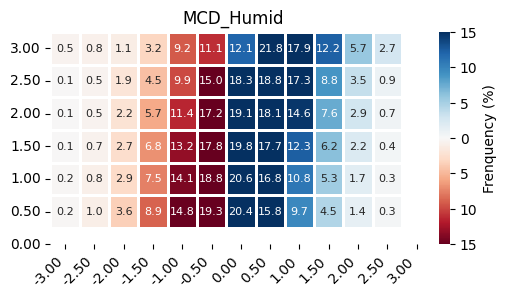

[[ 0.    0.73  0.73  4.38  3.65  8.76 10.22 20.44 21.9  10.22 10.22  3.65]
 [ 0.    0.22  0.73  3.81  6.09 11.88 18.48 17.67 17.82 12.1   7.99  2.93]
 [ 0.05  0.14  1.77  4.05  8.41 15.08 20.11 19.94 15.88  8.44  4.31  1.36]
 [ 0.07  0.46  1.79  4.62 10.05 17.49 21.9  20.26 13.65  6.38  2.21  0.83]
 [ 0.07  0.51  1.73  5.64 12.15 19.73 23.13 17.86 11.18  5.04  2.14  0.67]
 [ 0.08  0.51  2.18  6.54 15.66 22.42 22.01 16.03  8.6   3.97  1.39  0.48]]


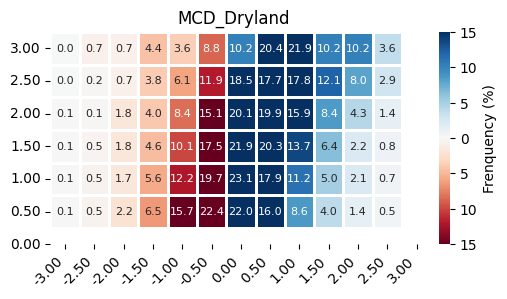

In [14]:
frequency_analysis().frenquency_heatmap(df_clean)

100%|███████████████████████| 18926/18926 [00:00<00:00, 209703.57it/s]


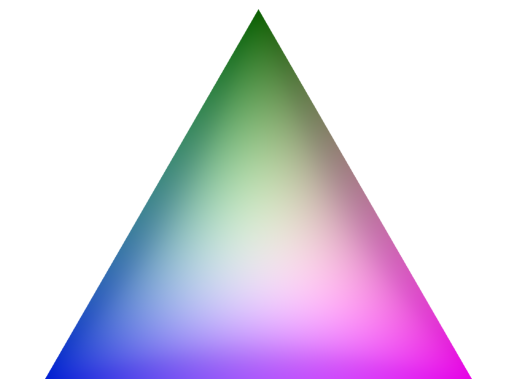

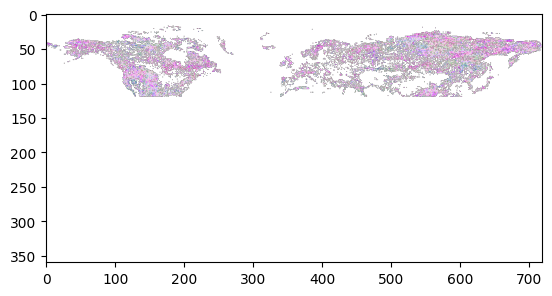

In [15]:
frequency_analysis().spatial_frequency()

In [22]:
def load_split_dataframe(fdir):
    # fdir = r"C:/Users/wenzhang1/PycharmProjects/Seasonal-stabilization-slowed-down-greening/Data/need_to_split/dataframe_zscore_LAI_split"
    df_list = []
    for f in T.listdir(fdir):

        dff = join(fdir, f)
        df = T.load_df(dff)
        df_list.append(df)
    df_total = pd.concat(df_list)
    
    return df_total


In [23]:
class SEM:
    def __init__(self):
        # This class is used to calculate the structural equation model

        self.outdir = result_root + 'SEM/'
        T.mkdir(self.outdir, force=True)

        pass

    def run(self):
        ## 1. load dataframe
        df = self.load_df()
        ## 2. model description
        des = self.model_description_detrend()

        ## 3. to select region of water-limited and energy-limited
        df_clean = self.clean_df(df)
        ## 4. run SEM model and save the result[remember change the model name for
        ##water-limited and energy-limited, seperately based on the selected region]
        self.SEM_model(df_clean, des)

        pass

    def load_df(self):
        df_dir = join(data_root,'dataframe_detrend_zscore_LAI_split')
        df = load_split_dataframe(df_dir)
        # df = T.load_df(dff)

        return df
        # return df_early,dff

    def clean_df(self, df):
        df = df[df['row'] < 120]
        # df = df[df['HI_class'] == 'Humid']
        df = df[df['HI_class'] == 'Dryland']
        df = df[df['max_trend'] < 10]
        df = df[df['early_peak_MCD'] > 0]

        df = df[df['landcover_GLC'] != 'Crop']

        return df


    def model_description_detrend(self):
        desc_all_limited_SMroot = '''
                             # regressions

                             early_peak_MCD~early_Temp+early_precip

                             late_SMroot~  early_peak_MCD+late_Temp+peak_precip

                             late_MCD ~ late_SMroot + late_Temp+late_precip


                             # residual correlations
                              early_peak_MCD~~early_peak_MCD
                                 late_SMroot~~late_SMroot
                                 late_MCD~~late_MCD

                                 early_peak_MCD~~early_Temp
                                 early_peak_MCD~~early_precip
                                 late_SMroot~~early_peak_MCD

                                 late_MCD~~late_SMroot
                                 late_SMroot~~late_Temp
                                 late_MCD~~late_Temp

                                 late_SMroot~~peak_precip

                                    late_MCD~~late_precip


                             '''

        return desc_all_limited_SMroot

    def SEM_model(self, df, desc):
        mod = semopy.Model(desc)
        res = mod.fit(df)

        result = mod.inspect()
        T.print_head_n(result)
        outf = self.outdir + f'water_limited_MCD'  #### save name
        T.save_df(result, outf + '.df')
        T.df_to_excel(result, outf + '.xlsx')

        outf = self.outdir + 'water_limited_MCD'
        semopy.report(mod, outf)


In [24]:
df=SEM().load_df()
df

,pix,early_peak_MCD,year,early_CABLE_POP_S2_lai,early_CLASSIC_S2_lai,early_CLM5_S2_lai,early_DLEM_S2_lai,early_IBIS_S2_lai,early_ISAM_S2_lai,early_ISBA_CTRIP_S2_lai,early_JSBACH_S2_lai,early_LPX-Bern_S2_lai,early_MCD,early_Trendy_ensemble,early_VISIT_S2_lai,early_YIBs_S2_Monthly_lai,peak_CABLE-POP_S2_lai,peak_CLASSIC_S2_lai,peak_CLM5_S2_lai,peak_DLEM_S2_lai,peak_IBIS_S2_lai,peak_ISAM_S2_lai,peak_ISBA_CTRIP_S2_lai,peak_JSBACH_S2_lai,peak_LPX-Bern_S2_lai,peak_MCD,peak_Trendy_ensemble,peak_VISIT_S2_lai,peak_YIBs_S2_Monthly_lai,late_CABLE_POP_S2_lai,late_CLASSIC_S2_lai,late_CLM5_S2_lai,late_DLEM_S2_lai,late_IBIS_S2_lai,late_ISAM_S2_lai,late_ISBA_CTRIP_S2_lai,late_JSBACH_S2_lai,late_LPX_Bern_S2_lai,late_MCD,late_Trendy_ensemble,late_VISIT_S2_lai,late_YIBs_S2_Monthly_lai,early_peak_CABLE_POP_S2_lai,early_peak_CLASSIC_S2_lai,early_peak_CLM5_S2_lai,early_peak_DLEM_S2_lai,early_peak_IBIS_S2_lai,early_peak_ISAM_S2_lai,early_peak_ISBA_CTRIP_S2_lai,early_peak_JSBACH_S2_lai,early_peak_LPX_Bern_S2_lai,early_peak_Trendy_ensemble,early_peak_VISIT_S2_lai,early_peak_YIBs_S2_Monthly_lai,row,max_trend,NDVI_MASK,landcover_GLC,HI_class,early_CLM5_S2_mrso,peak_CLM5_S2_mrso,late_CLM5_S2_mrso,early_peak_CLM5_S2_mrso,early_Et,early_precip,early_SMroot,early_SMsurf,early_Temp,peak_Et,peak_precip,peak_SMroot,peak_SMsurf,peak_Temp,late_Et,late_precip,late_SMroot,late_SMsurf,late_Temp,early_peak_Et,early_peak_precip,early_peak_SMroot,early_peak_SMsurf,early_peak_Temp,early_CABLE_POP_S2_mrso,early_CLASSIC_S2_mrso,early_IBIS_S2_mrso,early_ISAM_S2_mrso,early_ISBA_CTRIP_S2_mrso,early_JSBACH_S2_mrso,early_LPX_Bern_S2_mrso,early_VISIT_S2_mrso,peak_CABLE_POP_S2_mrso,peak_CLASSIC_S2_mrso,peak_IBIS_S2_mrso,peak_ISAM_S2_mrso,peak_ISBA_CTRIP_S2_mrso,peak_JSBACH_S2_mrso,peak_LPX_Bern_S2_mrso,peak_VISIT_S2_mrso,late_CABLE_POP_S2_mrso,late_CLASSIC_S2_mrso,late_IBIS_S2_mrso,late_ISAM_S2_mrso,late_ISBA_CTRIP_S2_mrso,late_JSBACH_S2_mrso,late_LPX_Bern_S2_mrso,late_VISIT_S2_mrso,early_peak_CABLE_POP_S2_mrso,early_peak_CLASSIC_S2_mrso,early_peak_IBIS_S2_mrso,early_peak_ISAM_S2_mrso,early_peak_ISBA_CTRIP_S2_mrso,early_peak_JSBACH_S2_mrso,early_peak_LPX_Bern_S2_mrso,early_peak_VISIT_S2_mrso
0,"(18, 177)",0.121491,2003,NaN,NaN,NaN,0.476543,NaN,NaN,-0.239059,NaN,NaN,-0.194051,0.580128,NaN,-0.597614,NaN,NaN,NaN,0.471320,NaN,NaN,0.067779,NaN,NaN,0.234658,0.626747,NaN,-0.597614,NaN,NaN,NaN,0.495712,NaN,NaN,0.303418,NaN,NaN,0.596793,0.808652,NaN,0.597614,NaN,NaN,NaN,0.472882,NaN,NaN,0.020780,NaN,NaN,0.620539,NaN,-0.597614,18,1.030075,1.0,Grass,Dryland,NaN,NaN,NaN,NaN,NaN,-0.319910,-0.023570,-0.023570,NaN,NaN,1.658225,0.226976,0.230962,NaN,NaN,-1.177769,-0.586847,-0.470027,-0.566656,NaN,1.474922,0.216605,0.220412,NaN,NaN,NaN,NaN,NaN,1.209888,NaN,0.728753,NaN,NaN,NaN,NaN,NaN,1.267945,NaN,-0.270609,NaN,NaN,NaN,NaN,-0.378467,-0.582707,NaN,-0.746519,NaN,NaN,NaN,NaN,NaN,1.249234,NaN,-0.105117,NaN
1,"(18, 177)",-1.277346,2004,NaN,NaN,NaN,-0.217329,NaN,NaN,-0.506646,NaN,NaN,-1.278542,0.331764,NaN,1.673320,NaN,NaN,NaN,-0.210469,NaN,NaN,-1.466858,NaN,NaN,-1.019317,-0.057178,NaN,1.673320,NaN,NaN,NaN,-0.448807,NaN,NaN,-1.769829,NaN,NaN,-0.189071,-1.025107,NaN,-1.673320,NaN,NaN,NaN,-0.212518,NaN,NaN,-1.623735,NaN,NaN,0.042791,NaN,1.673320,18,1.030075,1.0,Grass,Dryland,NaN,NaN,NaN,NaN,NaN,-0.364090,-0.047140,-0.047140,NaN,NaN,-1.176547,-0.057145,-0.054176,NaN,NaN,0.648876,0.645747,0.882086,-1.534644,NaN,-1.307027,-0.056761,-0.053914,NaN,NaN,NaN,NaN,NaN,-0.602383,NaN,-1.465640,NaN,NaN,NaN,NaN,NaN,-0.603619,NaN,1.359542,NaN,NaN,NaN,NaN,-0.404973,-1.381996,NaN,1.025777,NaN,NaN,NaN,NaN,NaN,-0.604207,NaN,1.005306,NaN
2,"(18, 177)",0.263503,2005,NaN,NaN,NaN,-1.568466,NaN,NaN,0.488243,NaN,NaN,-0.151847,-1.322252,NaN,-0.597614,NaN,NaN,NaN,-1.571499,NaN,NaN,-0.900230,NaN,NaN,0.391583,-1.381937,NaN,-0.597614,NaN,NaN,NaN,-1.626299,NaN,NaN,-0.578159,NaN,NaN,1.010725,-1.338233,NaN,0.597614,NaN,NaN,NaN,-1.570604,NaN,NaN,-0.831332,NaN,NaN,-1.379387,NaN,-0.597614,18,1.030075,1.0,Grass,Dryland,NaN,NaN,NaN,NaN,NaN,

In [25]:
des=SEM().model_description_detrend()
des

'\n                             # regressions\n\n                             early_peak_MCD~early_Temp+early_precip\n\n                             late_SMroot~  early_peak_MCD+late_Temp+peak_precip\n\n                             late_MCD ~ late_SMroot + late_Temp+late_precip\n\n\n                             # residual correlations\n                              early_peak_MCD~~early_peak_MCD\n                                 late_SMroot~~late_SMroot\n                                 late_MCD~~late_MCD\n\n                                 early_peak_MCD~~early_Temp\n                                 early_peak_MCD~~early_precip\n                                 late_SMroot~~early_peak_MCD\n\n                                 late_MCD~~late_SMroot\n                                 late_SMroot~~late_Temp\n                                 late_MCD~~late_Temp\n\n                                 late_SMroot~~peak_precip\n\n                                    late_MCD~~late_precip\n\n\n     

In [26]:
df_clean = SEM().clean_df(df)
df_clean

,pix,early_peak_MCD,year,early_CABLE_POP_S2_lai,early_CLASSIC_S2_lai,early_CLM5_S2_lai,early_DLEM_S2_lai,early_IBIS_S2_lai,early_ISAM_S2_lai,early_ISBA_CTRIP_S2_lai,early_JSBACH_S2_lai,early_LPX-Bern_S2_lai,early_MCD,early_Trendy_ensemble,early_VISIT_S2_lai,early_YIBs_S2_Monthly_lai,peak_CABLE-POP_S2_lai,peak_CLASSIC_S2_lai,peak_CLM5_S2_lai,peak_DLEM_S2_lai,peak_IBIS_S2_lai,peak_ISAM_S2_lai,peak_ISBA_CTRIP_S2_lai,peak_JSBACH_S2_lai,peak_LPX-Bern_S2_lai,peak_MCD,peak_Trendy_ensemble,peak_VISIT_S2_lai,peak_YIBs_S2_Monthly_lai,late_CABLE_POP_S2_lai,late_CLASSIC_S2_lai,late_CLM5_S2_lai,late_DLEM_S2_lai,late_IBIS_S2_lai,late_ISAM_S2_lai,late_ISBA_CTRIP_S2_lai,late_JSBACH_S2_lai,late_LPX_Bern_S2_lai,late_MCD,late_Trendy_ensemble,late_VISIT_S2_lai,late_YIBs_S2_Monthly_lai,early_peak_CABLE_POP_S2_lai,early_peak_CLASSIC_S2_lai,early_peak_CLM5_S2_lai,early_peak_DLEM_S2_lai,early_peak_IBIS_S2_lai,early_peak_ISAM_S2_lai,early_peak_ISBA_CTRIP_S2_lai,early_peak_JSBACH_S2_lai,early_peak_LPX_Bern_S2_lai,early_peak_Trendy_ensemble,early_peak_VISIT_S2_lai,early_peak_YIBs_S2_Monthly_lai,row,max_trend,NDVI_MASK,landcover_GLC,HI_class,early_CLM5_S2_mrso,peak_CLM5_S2_mrso,late_CLM5_S2_mrso,early_peak_CLM5_S2_mrso,early_Et,early_precip,early_SMroot,early_SMsurf,early_Temp,peak_Et,peak_precip,peak_SMroot,peak_SMsurf,peak_Temp,late_Et,late_precip,late_SMroot,late_SMsurf,late_Temp,early_peak_Et,early_peak_precip,early_peak_SMroot,early_peak_SMsurf,early_peak_Temp,early_CABLE_POP_S2_mrso,early_CLASSIC_S2_mrso,early_IBIS_S2_mrso,early_ISAM_S2_mrso,early_ISBA_CTRIP_S2_mrso,early_JSBACH_S2_mrso,early_LPX_Bern_S2_mrso,early_VISIT_S2_mrso,peak_CABLE_POP_S2_mrso,peak_CLASSIC_S2_mrso,peak_IBIS_S2_mrso,peak_ISAM_S2_mrso,peak_ISBA_CTRIP_S2_mrso,peak_JSBACH_S2_mrso,peak_LPX_Bern_S2_mrso,peak_VISIT_S2_mrso,late_CABLE_POP_S2_mrso,late_CLASSIC_S2_mrso,late_IBIS_S2_mrso,late_ISAM_S2_mrso,late_ISBA_CTRIP_S2_mrso,late_JSBACH_S2_mrso,late_LPX_Bern_S2_mrso,late_VISIT_S2_mrso,early_peak_CABLE_POP_S2_mrso,early_peak_CLASSIC_S2_mrso,early_peak_IBIS_S2_mrso,early_peak_ISAM_S2_mrso,early_peak_ISBA_CTRIP_S2_mrso,early_peak_JSBACH_S2_mrso,early_peak_LPX_Bern_S2_mrso,early_peak_VISIT_S2_mrso
0,"(18, 177)",0.121491,2003,NaN,NaN,NaN,0.476543,NaN,NaN,-0.239059,NaN,NaN,-0.194051,0.580128,NaN,-0.597614,NaN,NaN,NaN,0.471320,NaN,NaN,0.067779,NaN,NaN,0.234658,0.626747,NaN,-0.597614,NaN,NaN,NaN,0.495712,NaN,NaN,0.303418,NaN,NaN,0.596793,0.808652,NaN,0.597614,NaN,NaN,NaN,0.472882,NaN,NaN,0.020780,NaN,NaN,0.620539,NaN,-0.597614,18,1.030075,1.0,Grass,Dryland,NaN,NaN,NaN,NaN,NaN,-0.319910,-0.023570,-0.023570,NaN,NaN,1.658225,0.226976,0.230962,NaN,NaN,-1.177769,-0.586847,-0.470027,-0.566656,NaN,1.474922,0.216605,0.220412,NaN,NaN,NaN,NaN,NaN,1.209888,NaN,0.728753,NaN,NaN,NaN,NaN,NaN,1.267945,NaN,-0.270609,NaN,NaN,NaN,NaN,-0.378467,-0.582707,NaN,-0.746519,NaN,NaN,NaN,NaN,NaN,1.249234,NaN,-0.105117,NaN
2,"(18, 177)",0.263503,2005,NaN,NaN,NaN,-1.568466,NaN,NaN,0.488243,NaN,NaN,-0.151847,-1.322252,NaN,-0.597614,NaN,NaN,NaN,-1.571499,NaN,NaN,-0.900230,NaN,NaN,0.391583,-1.381937,NaN,-0.597614,NaN,NaN,NaN,-1.626299,NaN,NaN,-0.578159,NaN,NaN,1.010725,-1.338233,NaN,0.597614,NaN,NaN,NaN,-1.570604,NaN,NaN,-0.831332,NaN,NaN,-1.379387,NaN,-0.597614,18,1.030075,1.0,Grass,Dryland,NaN,NaN,NaN,NaN,NaN,0.127525,-0.070711,-0.070711,NaN,NaN,-0.307418,-0.330365,-0.328402,NaN,NaN,-0.570289,-1.557182,-1.629918,-0.368686,NaN,-0.243366,-0.319676,-0.317778,NaN,NaN,NaN,NaN,NaN,-0.511301,NaN,0.749502,NaN,NaN,NaN,NaN,NaN,-0.454764,NaN,1.268388,NaN,NaN,NaN,NaN,-0.431478,-0.266065,NaN,0.876824,NaN,NaN,NaN,NaN,NaN,-0.475875,NaN,1.397986,NaN
4,"(18, 177)",1.449390,2007,NaN,NaN,NaN,-0.488310,NaN,NaN,3.451682,NaN,NaN,0.346207,-0.872175,NaN,-0.597614,NaN,NaN,NaN,-0.485785,NaN,NaN,-0.448045,NaN,NaN,1.638476,-1.095766,NaN,-0.597614,NaN,NaN,NaN,-0.150047,NaN,NaN,1.938936,NaN,NaN,-0.344249,-0.129956,NaN,0.597614,NaN,NaN,NaN,-0.486542,NaN,NaN,0.249422,NaN,NaN,-1.048198,NaN,-0.597614,18,1.030075,1.0,Grass,Dryland,NaN,NaN,NaN,NaN,NaN,-

In [27]:
SEM().SEM_model(df_clean, des)

             lval  op            rval  Estimate  Std. Err    z-value  \
0  early_peak_MCD   ~      early_Temp  0.282159  0.045842   6.154980   
1  early_peak_MCD   ~    early_precip  0.705252  0.061031  11.555682   
2     late_SMroot   ~  early_peak_MCD -0.458335  0.058813  -7.793063   
3     late_SMroot   ~       late_Temp -0.136416  0.031593  -4.317945   
4     late_SMroot   ~     peak_precip  4.061561  0.084679  47.964196   
5        late_MCD   ~     late_SMroot  0.909976  0.063386  14.356191   
6        late_MCD   ~       late_Temp  0.561335  0.051386  10.923978   
7        late_MCD   ~     late_precip -0.149979  0.190597  -0.786891   
8  early_peak_MCD  ~~  early_peak_MCD  0.608101  0.066039   9.208221   
9  early_peak_MCD  ~~      early_Temp -0.053793  0.027786  -1.935958   

        p-value  
0  7.508685e-10  
1  0.000000e+00  
2  6.439294e-15  
3  1.574886e-05  
4  0.000000e+00  
5  0.000000e+00  
6  0.000000e+00  
7  4.313455e-01  
8  0.000000e+00  
9  5.287284e-02  
Dataframe

In [32]:
class SEM_anaysis():  #### SEM result comparision between observation and model
    def __init__(self):
        self.this_class_arr = result_root + 'SEM_anaysis/'
        T.mk_dir(self.this_class_arr, force=1)
        pass
    def run(self):
        region_water_limited = 'water_limited'
        region_energy_limited = 'energy_limited'
        self.SEM_process_comparision(region_water_limited)
        self.SEM_process_comparision(region_energy_limited)
        pass

    def SEM_process_comparision(self,region):
        marker_list = ['o', 's', 'D', 'v', 'p', 'P', '^', 'X', 'd']
        # color_list=['g','b','y','c','m','k','orange','purple','brown']
        color_list = T.gen_colors(9)

        fdir = join(self.this_class_arr, 'df_model')
        # region = 'water_limited'
        val_list = []
        result_dict = {}

        ax=plt.subplot(111)

        for f in T.listdir(fdir):
            if not f.endswith('.df'):
                continue
            if not f.startswith(region):
                continue
            # print(f)
            model = f.split('.')[0].replace(region + '_', '').replace('_lai', '')
            path_list_l = self.path_list_left(model)
            path_list_r = self.path_list_right(model)
            dff = join(fdir, f)
            df = T.load_df(dff)
            df = df[df['op'] != '~~']

            for i in range(len(path_list_l)):
                lv = path_list_l[i]
                rv = path_list_r[i]

                df_l = df[df['lval'] == lv]
                df_r = df_l[df_l['rval'] == rv]
                # print (df_r)

                if len(df_r) != 1:
                    print(len(df_r))
                    raise ValueError
                Estimate = df_r['Estimate'].values[0]
                # print(Estimate)
                lv = lv.replace(model + '_', '')
                rv = rv.replace(model + '_', '')
                key = f'{rv}--->{lv}'
                if not key in result_dict:
                    result_dict[key] = {}
                result_dict[key][model] = Estimate
                # result_dict[key] = Estimate
        df_result = T.dic_to_df(result_dict, 'path')
        # print(df_result)
        # T.print_head_n(df_result)
        obs_SEM_result = self.obs_SEM(region)
        path = df_result['path']
        boxes = []
        x_lable = []

        for p in path:
            flag = 0
            df_p = df_result[df_result['path'] == p]

            vals = df_p.values[0]
            vals_i_list = []
            for v in vals:
                if type(v) == float:
                    vals_i_list.append(v)

                    # print(flag)

                    # print(df_p.columns)
                    model_name = df_p.columns[flag+1]
                    plt.scatter(v,p, marker=marker_list[flag], color=color_list[flag], s=30,zorder=5,linewidths=0.5,edgecolors='k',label=model_name)
                    flag+=1
            boxes.append(vals_i_list)
            x_lable.append(p)
            # plt.scatter(vals_i_list, [p for i in range(len(vals_i_list))], marker=marker_list[flag], color=color_list[flag], s=50)
        # x_lable_obs = obs_SEM_result.keys()

        # x_lable_obs = list(x_lable_obs)

        vals_obs = [obs_SEM_result[x] for x in x_lable]
        plt.boxplot(boxes, labels=x_lable, showfliers=False, vert=False, positions=range(len(x_lable)),zorder=100,patch_artist=True,boxprops=dict(facecolor='none', color='k'),whiskerprops=dict(color='black'),medianprops=dict(color='black'))

        plt.scatter(vals_obs, x_lable, marker='*', color='r', s=100,zorder=10)
        ### reverse the y axis
        plt.gca().invert_yaxis()
        plt.title(region)
        # plt.legend()

        plt.tight_layout()
        plt.show()

    def obs_SEM(self, region):
        fdir = join(self.this_class_arr, 'df_obs')
        # region = 'water_limited'
        fpath = join(fdir, f'{region}_MCD.df')
        df = T.load_df(fpath)
        df = df[df['op'] == '~']
        path_list = []
        
        results_dict = {}
        for i, row in df.iterrows():
            lv = row['lval']
            rv = row['rval']
            # print(lv, rv)
            lv = lv.replace('MCD', 'lai')
            rv = rv.replace('MCD', 'lai')

            lv = lv.replace('SMroot', 'mrso')
            rv = rv.replace('SMroot', 'mrso')
            label = f'{rv}--->{lv}'
            # path_list.append(f'{rv}--->{lv}')
            val = row['Estimate']
            results_dict[label] = val
        return results_dict

    def path_list_left(self, model):
        path_list = [
            f'early_peak_{model}_lai',
            f'early_peak_{model}_lai',

            f'late_{model}_mrso',
            f'late_{model}_mrso',
            f'late_{model}_mrso',


            f'late_{model}_lai',
            f'late_{model}_lai',
            f'late_{model}_lai',
        ]
        return path_list

    def path_list_right(self,model):
        path_list = [
            'early_Temp',
            'early_precip',

            f'early_peak_{model}_lai',
            'peak_precip',
            'late_Temp',

            f'late_{model}_mrso',
            'late_Temp',
            'late_precip',
        ]
        return path_list


100%|███████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


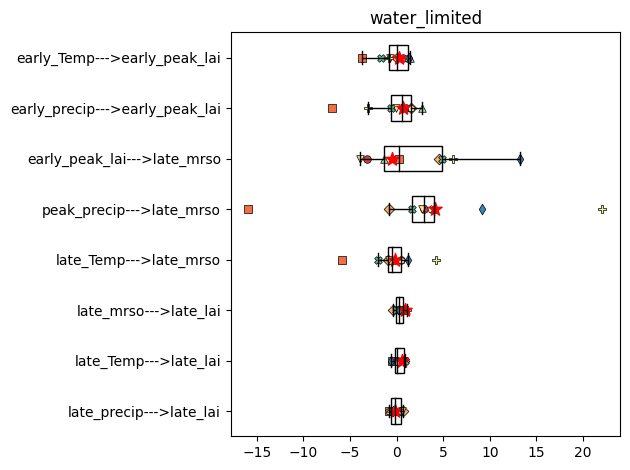

In [33]:
region_water_limited = 'water_limited'
SEM_anaysis().SEM_process_comparision(region_water_limited)

100%|███████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


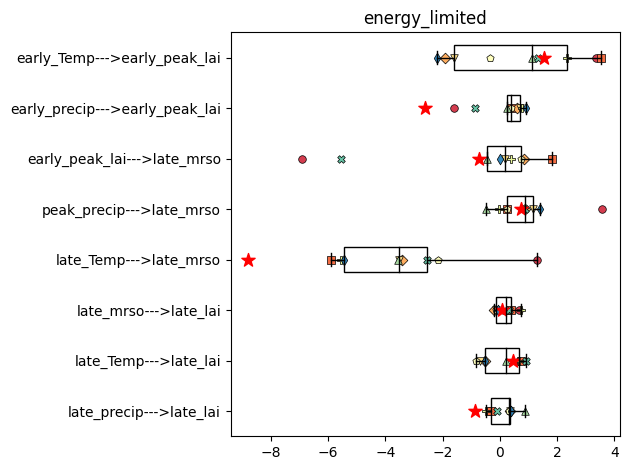

In [34]:
region_energy_limited = 'energy_limited'
SEM_anaysis().SEM_process_comparision(region_energy_limited)

In [39]:
class Stabilization_amplification_longterm_trends:

    def __init__(self):

        pass
    def run(self):
        ##1 based on the zscore result, calculate the long term trend for models and observation and save results
        # self.calcualte_long_term_trend()

        ##2 calculate the average zscore time series for individual product and save results
        self.calculate_average()

        ##3 plot the time series of zscore of individual product and observation
        self.plot_time_series_zscore()

        ##4 calculate the temporal change of stabilization trends
        # self.calculate_stabilization_temporal_change_statistic()

        ## 5 composite the results of  stabilization trends and LAI trends over 2003-2021
        # self.zscore_vs_stabilization_composition()

        ##5 plot the feedback vs trend
        self.plot_feedback_vs_trend()



        pass


    def calcualte_long_term_trend(self):
        df_dir = join(data_root,'dataframe_zscore_LAI_split')
        df=load_split_dataframe(df_dir)

        df = df[df['row'] < 120]

        df = df[df['max_trend'] < 10]

        df = df[df['landcover_GLC'] != 'Crop']
        period_name = ['early_peak', 'late', 'early_peak_late']
        product_list = ['MCD', 'CABLE-POP_S2_lai', 'CLASSIC_S2_lai', 'CLM5', 'IBIS_S2_lai',
                        'ISAM_S2_LAI', 'ISBA-CTRIP_S2_lai', 'JSBACH_S2_lai',
                        'LPX-Bern_S2_lai', 'VISIT_S2_lai', 'YIBs_S2_Monthly_lai', ]

        result_dic = {}
        for region in ['Humid', 'Dryland']:

            for period in period_name:

                df_pick = df[df['HI_class'] == region]

                for variable in tqdm(product_list,desc=f'{region}_{period}'):
                    column_name = f'{period}_{variable}'

                    # print(column_name)

                    mean_value_yearly, up_list, bottom_list, fit_value_yearly, k_value, p_value = self.plot_calculation(
                        df_pick, column_name)

                    key = f'{region}_{period}_{variable}'
                    result_dic[key] = {
                        'mean_value_yearly': mean_value_yearly,
                        'up_list': up_list,
                        'bottom_list': bottom_list,
                        'fit_value_yearly': fit_value_yearly,
                        'k_value': k_value,
                        'p_value': p_value,

                    }
        outdir = result_root + rf'/zscore_result_statistical_annual/'
        T.mk_dir(outdir, force=1)
        outf = outdir + 'zscore_result_statistical_annual.npy'
        T.save_npy(result_dic, outf)
    pass


    def plot_calculation(self,df,column_name):
        dic = {}
        mean_val = {}
        confidence_value = {}
        std_val = {}
        # year_list = df['year'].to_list()
        # year_list = set(year_list)  #
        # year_list = list(year_list)
        # year_list.sort()

        year_list = []
        for i in range(2003, 2022):
            year_list.append(i)
        # print(year_list)

        for year in year_list:  #
            dic[year] = []
            mean_val[year] = []
            confidence_value[year] = []

        for year in year_list:
            df_pick = df[df['year'] == year]
            for i, row in df_pick.iterrows():
                pix = row.pix
                val = row[column_name]
                dic[year].append(val)
            val_list = np.array(dic[year])
            # val_list[val_list>1000]=np.nan

            n = len(val_list)
            mean_val_i = np.nanmean(val_list)
            std_val_i = np.nanstd(val_list)
            se = stats.sem(val_list)
            h = se * stats.t.ppf((1 + 0.95) / 2., n - 1)
            confidence_value[year] = h
            mean_val[year] = mean_val_i
            std_val[year] = std_val_i

        # a, b, r = KDE_plot().linefit(xaxis, val)
        mean_val_list = []

        for year in year_list:
            mean_val_list.append(mean_val[year])
        xaxis = range(len(mean_val_list))
        xaxis = list(xaxis)
        # print(len(mean_val_list))
        # r, p_value = stats.pearsonr(xaxis, mean_val_list)
        # k_value, b_value = np.polyfit(xaxis, mean_val_list, 1)
        k_value, b_value, r, p_value = T.nan_line_fit(xaxis, mean_val_list)
        # print(k_value)

        mean_value_yearly = []
        up_list = []
        bottom_list = []
        fit_value_yearly = []
        p_value_yearly = []

        for year in year_list:
            mean_value_yearly.append(mean_val[year])
            # up_list.append(mean_val[year] + confidence_value[year])
            # bottom_list.append(mean_val[year] - confidence_value[year])
            up_list.append(mean_val[year] + 0.125 * std_val[year])
            bottom_list.append(mean_val[year] - 0.125 * std_val[year])

            fit_value_yearly.append(k_value * (year - year_list[0]) + b_value)



        return mean_value_yearly, up_list, bottom_list, fit_value_yearly, k_value, p_value
        # exit()
    def calculate_average(self):


        df_dir = join(data_root, 'dataframe_zscore_LAI_split')
        df = load_split_dataframe(df_dir)
        f_individual = result_root + rf'/zscore_result_statistical_annual/zscore_result_statistical_annual.npy'
        dic_individual = T.load_npy(f_individual)
        # print(dic_individual)
        # pprint.pprint(dic_individual)
        # exit()


        product_list = [ 'CABLE-POP_S2_lai', 'CLASSIC_S2_lai', 'CLM5', 'IBIS_S2_lai',
                        'ISAM_S2_LAI', 'ISBA-CTRIP_S2_lai', 'JSBACH_S2_lai',
                        'LPX-Bern_S2_lai', 'VISIT_S2_lai', 'YIBs_S2_Monthly_lai', ]
        period_name = ['early_peak', 'late', 'early_peak_late']
        region_list = ['Humid', 'Dryland']
        # T.print_head_n(df)
        # exit()
        # result_dic = {}
        for region in region_list:
            for period in period_name:
                whole_list = []
                for product in tqdm(product_list,desc=f'{region}_{period}'):
                    column_name = f'{period}_{product}'
                    df_pick = df[df['HI_class'] == region]

                    mean_value_yearly, up_list, bottom_list, fit_value_yearly, k_value, p_value = self.plot_calculation(
                        df_pick, column_name)
                    whole_list.append(mean_value_yearly)
                        ## average
                average_list = np.nanmean(whole_list, axis=0)
                ## calculate k,p
                xaxis = range(len(average_list))
                xaxis = list(xaxis)
                k_value, b_value, r, p_value = T.nan_line_fit(xaxis, average_list)
                fit_value_yearly_average = []
                for year in range(2003, 2022):

                    fit_value_yearly_average.append(k_value * (year - 2003) + b_value)

                dic_individual[f'{region}_{period}_average'] = {
                    'mean_value_yearly': average_list,
                    'up_list':[],
                    'bottom_list': [],
                    'fit_value_yearly': fit_value_yearly_average,
                    'k_value': k_value,
                    'p_value': p_value,}
                # pprint.pprint(result_dic)
                # dic_individual.update(result_dic)
                # exit()

        outdir = result_root + rf'/zscore_result_statistical_annual/'
        T.mk_dir(outdir, force=1)
        outf = outdir + 'zscore_result_statistical_annual_average.npy'
        T.save_npy(dic_individual, outf)
        # pprint.pprint(dic_individual)



    def plot_time_series_zscore(self):  ###plot time series
        f = result_root + rf'/zscore_result_statistical_annual/zscore_result_statistical_annual_average.npy'
        dic = T.load_npy(f)
        period_name = ['early_peak', 'late', 'early_peak_late']

        product_list = ['MCD', 'average', 'CABLE-POP_S2_lai', 'CLASSIC_S2_lai', 'CLM5', 'IBIS_S2_lai',
                        'ISAM_S2_LAI', 'ISBA-CTRIP_S2_lai', 'JSBACH_S2_lai',
                        'LPX-Bern_S2_lai', 'VISIT_S2_lai', 'YIBs_S2_Monthly_lai', ]
        color_list = ['green', 'black']
        color_list.extend('silver' for i in range(len(product_list) - 2))
        linewidth_list = [2, 2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
                          0.5]

        centimeter = 1 / 2.54


        fig = plt.figure(figsize=(18 * centimeter, 12 * centimeter))
        i = 1

        for region in ['Dryland','Humid']:

            for period in period_name:
                ax = fig.add_subplot(2, 3, i)

                flag = 0
                for variable in product_list:

                    color = color_list[flag]
                    linewidth = linewidth_list[flag]
                    if flag >= 2:
                        zorder = 0
                    else:
                        zorder = 1

                    flag += 1
                    key = f'{region}_{period}_{variable}'
                    result_i = dic[key]
                    mean_value_yearly = result_i['mean_value_yearly']
                    # up_list = result_i['up_list']
                    # bottom_list = result_i['bottom_list']
                    fit_value_yearly = result_i['fit_value_yearly']
                    k_value = result_i['k_value']
                    p_value = result_i['p_value']
                    # print(f'{region}_{variable}', 'k={:0.2f},p={:0.4f}'.format(k_value, p_value))
                    yearlist=range(2003,2022)

                    plt.plot(yearlist,mean_value_yearly, label=variable, c=color, zorder=zorder, linewidth=linewidth)
                    plt.plot(yearlist,fit_value_yearly, linestyle='--', label='k={:0.2f},p={:0.2f}'.format(k_value, p_value),
                             c=color, linewidth=linewidth)
                    # print(f'{region}_{variable}','k={:0.2f},p={:0.4f}'.format(k_value, p_value))
                    # plt.fill_between(range(len(mean_value_yearly)), up_list, bottom_list, alpha=0.1, zorder=-1,
                    #                  color=color)



                plt.ylabel('zscore')
                plt.xlabel('year')
                major_xticks = np.arange(2003, 2022, 5)
                plt.xticks(major_xticks, rotation=45)
                plt.title(f'{period}_{region}')

                # major_yticks = np.arange(-10, 15, 5)
                major_yticks = np.arange(-0.8, 0.9, 0.4)
                plt.ylim(-0.8, 0.8)
                # major_ticks = np.arange(0, 40, 5)  ###
                ax.set_xticks(major_xticks)
                ax.set_yticks(major_yticks)
                plt.grid(which='major', alpha=0.5)
                plt.tight_layout()
                i = i + 1
        plt.show()
        # outdir = result_root + rf'/Data_frame/zscore_result_statistical_annual/'
        # T.mk_dir(outdir, force=1)
        # outf = outdir + 'zscore_result_statistical_annual_average.pdf'
        # plt.savefig(outf)
        # plt.close()





    def calculate_stabilization_temporal_change_statistic(self):
        outdir = join(result_root, 'stabilization_temporal_change_statistic')
        T.mk_dir(outdir)
        fdir_early = join(data_root, 'zscore_LAI/early_peak')
        fdir_late = join(data_root, 'zscore_LAI/late')
        # fdir_late = join(data_root, 'LAI3g_MCD_2003_2018/late')

        # print(len(year_list))
        # exit()
        result_dict = {}
        for f in T.listdir(fdir_early):

            fpath_early = join(fdir_early, f)
            fpath_late = join(fdir_late, f)
            early_dict = T.load_npy(fpath_early)
            late_dict = T.load_npy(fpath_late)
            for pix in late_dict:
                vals = late_dict[pix]
                # print(len(vals))
                # plt.plot(vals)
                # plt.show()
                # print(f, len(vals))
                start_year = 2003
                end_year = 2003 + len(vals) - 1
                year_list = list(range(start_year, end_year + 1))
                # print(len(year_list))
                break
            # exit()
            all_dict = {
                'early': early_dict,
                'late': late_dict,
            }
            df = T.spatial_dics_to_df(all_dict)
            # T.print_head_n(df)
            # exit()
            variable_list = ['early', 'late']
            df = Dataframe_per_value_transform(df, variable_list, start_year, end_year).df
            if len(df) == 0:
                raise
            # T.print_head_n(df)
            # exit()
            # df = df.dropna(how='any',subset=variable_list)

            df = build_dataframe().add_max_trend_to_df(df)
            df = build_dataframe().add_row(df)

            df = build_dataframe().add_max_trend_to_df(df)

            df = build_dataframe().add_NDVI_mask(df)

            df = build_dataframe().add_GLC_landcover_data_to_df(df)

            P_PET_dic = build_dataframe().P_PET_ratio(build_dataframe().P_PET_fdir)
            P_PET_reclass_dic = build_dataframe().P_PET_reclass_2(P_PET_dic)
            df = T.add_spatial_dic_to_df(df, P_PET_reclass_dic, 'HI_class')

            # T.print_head_n(df)
            # exit()
            for AI in ['Dryland', 'Humid']:
                df_AI = df[df['HI_class'] == AI]
                df_AI = df_AI[df_AI['early'] >= 0]
                # year_list = list(range(2002,2021))
                year_list_obj = []
                for year in year_list:
                    year_list_obj.append(int(year))

                bar_amplification = []
                bar_weak_stabilization = []
                bar_strong_stabilization = []
                for year in year_list:
                    df_year = df_AI[df_AI['year'] == year]
                    early_vals = df_year['early'].tolist()
                    late_vals = df_year['late'].tolist()
                    father = len(early_vals)
                    son_amplification = 0
                    son_weak_stabilization = 0
                    son_strong_stabilization = 0
                    for i in range(len(early_vals)):
                        early_val = early_vals[i]
                        late_val = late_vals[i]
                        if late_val > early_val:
                            son_amplification += 1
                        elif late_val < early_val and late_val > 0:
                            son_weak_stabilization += 1
                        else:
                            son_strong_stabilization += 1
                    ratio_amplification = son_amplification / father
                    ratio_weak_stabilization = son_weak_stabilization / father
                    ratio_strong_stabilization = son_strong_stabilization / father
                    bar_amplification.append(ratio_amplification)
                    bar_weak_stabilization.append(ratio_weak_stabilization)
                    bar_strong_stabilization.append(ratio_strong_stabilization)
                bar_amplification = np.array(bar_amplification)
                bar_weak_stabilization = np.array(bar_weak_stabilization)
                bar_strong_stabilization = np.array(bar_strong_stabilization)
                # plt.figure(figsize=(18*centimeter_factor,6*centimeter_factor))
                # plt.plot(year_list,bar_amplification,label='amplification')
                # plt.plot(year_list,bar_weak_stabilization,label='weak_stabilization')
                # plt.plot(year_list,bar_strong_stabilization,label='strong_stabilization')
                a_amp, _, _, p_amp = T.nan_line_fit(year_list, bar_amplification)
                a_weak_stab, _, _, p_weak_stab = T.nan_line_fit(year_list, bar_weak_stabilization)
                a_strong_stab, _, _, p_strong_stab = T.nan_line_fit(year_list, bar_strong_stabilization)
                key = f'{AI}-{f.replace(".npy", "")}'
                result_dict[key] = {
                    'a_amp': a_amp,
                    'a_weak_stab': a_weak_stab,
                    'a_strong_stab': a_strong_stab,
                    'p_amp': p_amp,
                    'p_weak_stab': p_weak_stab,
                    'p_strong_stab': p_strong_stab
                }
        df_result = T.dic_to_df(result_dict, 'model')
        T.print_head_n(df_result)
        outf = join(outdir, 'stabilization_temporal_change_statistic.df')
        T.save_df(df_result, outf)
        T.df_to_excel(df_result, outf)

    def zscore_vs_stabilization_composition(self):  ### compose stabilization trends and LAI trends over 2003-2021
        f_trend = result_root + rf'/zscore_result_statistical_annual/zscore_result_statistical_annual.npy'
        dic_trend = T.load_npy(f_trend)
        dff=result_root+rf'/stabilization_temporal_change_statistic/stabilization_temporal_change_statistic.df'
        df=T.load_df(dff)
        outdir=result_root+rf'/zscore_vs_stabilization_composition/'
        T.mk_dir(outdir,force=1)
        dff_new = outdir + 'zscore_vs_stabilization_composition.df'
        period_name = ['early_peak', 'late','early_peak_late']
        product_list = ['MCD',  'CABLE-POP_S2_lai', 'CLASSIC_S2_lai', 'CLM5', 'IBIS_S2_lai',
                        'ISAM_S2_LAI', 'ISBA-CTRIP_S2_lai', 'JSBACH_S2_lai',
                        'LPX-Bern_S2_lai', 'VISIT_S2_lai', 'YIBs_S2_Monthly_lai', ]
        # T.rename_dataframe_columns()
        model_name = df['model'].to_list()
        new_model_name_list = []
        for model in model_name:
            new_model_name = model.replace('Arid-', 'Dryland-')
            new_model_name_list.append(new_model_name)
        df = df.drop(columns='model')
        df['model'] = new_model_name_list
        # T.print_head_n(df)
        # exit()
        dict_result = {}


        for region in ['Humid', 'Dryland']:

            for variable in product_list:
                dict_j = {}
                new_key = f'{region}-{variable}'

                for period in period_name:

                    key = f'{region}_{period}_{variable}'

                    result_i = dic_trend[key]
                    k_value = result_i['k_value']
                    p_value = result_i['p_value']
                    dict_i = {
                        f'k_value_{period}': k_value,
                        f'p_value_{period}': p_value,
                    }
                    dict_j.update(dict_i)
                dict_result[new_key]=dict_j

        df_result = T.dic_to_df(dict_result,'model')
        # T.print_head_n(df_result)
        # exit()
        model_list = df_result['model'].to_list()
        print(model_list)
        T.print_head_n(df_result)
        ###save to df
        # df = pd.merge(df, df_result, on='model', how='left')
        # df_merge = pd.DataFrame()
        df_list = [df_result]
        print('-------------------')
        T.print_head_n(df)
        print('-------------------')
        T.print_head_n(df_result)
        df_merge = T.join_df_list(df,df_list,'model')
        df_merge = df_merge.dropna(how='any')
        T.print_head_n(df_merge)

        T.save_df(df_merge, dff_new)
        ##to excel
        T.df_to_excel(df_merge,dff_new, n=1000, random=False)

    def plot_feedback_vs_trend(self):
        dff=result_root+rf'/zscore_vs_stabilization_composition/zscore_vs_stabilization_composition.df'
        df=T.load_df(dff)
        marker_list = ['*','o', 's', 'D', 'v', 'p', 'P', '^', 'X', 'd', '<', '>']


        color_list = T.gen_colors(12)

        ##plot x =feedback and y = trend
        periods = ['late']
        product_list = ['MCD', 'CABLE-POP_S2_lai', 'CLASSIC_S2_lai', 'CLM5', 'IBIS_S2_lai',
            'ISAM_S2_LAI', 'ISBA-CTRIP_S2_lai', 'JSBACH_S2_lai',
            'LPX-Bern_S2_lai', 'VISIT_S2_lai',  ]
        region_list=['Humid','Dryland']

        for region in region_list:

            for period in periods:
                x_list = []
                y_list = []
                label_list = []
                p_value_list_sta=[]
                p_value_list_trend=[]
                flag = 0
                for variable in product_list:

                    key=f'{region}-{variable}'
                    df_pick=df[df['model']==key]
                    y=df_pick[f'k_value_{period}'].to_list()
                    x=df_pick[f'a_strong_stab'].to_list()
                    x=x[0]*100
                    y=y[0]

                    p_value_sta=df_pick[f'p_strong_stab'].to_list()
                    p_value_trend=df_pick[f'p_value_{period}'].to_list()
                    x_list.append(x)

                    y_list.append(y)
                    p_value_list_sta.append(p_value_sta)
                    p_value_list_trend.append(p_value_trend)

                    label_list.append(f'{region}-{variable}-{period}')

                # plt.figure(figsize=(9/centimeter, 7/centimeter))

                for i in range(len(x_list)):
                    x=x_list[i]
                    y=y_list[i]
                    label=label_list[i]
                    p_value_trend=p_value_list_trend[i]

                    p_value_sta=p_value_list_sta[i]
                    plt.scatter(x,y,label=label,marker=marker_list[flag],color=color_list[flag])
                    plt.text(x, y, f'P={p_value_trend[0]:0.2f}/nP={p_value_sta[0]:0.2f}', fontsize=6, color='black')

                    flag+=1

                plt.title(f'{region}-{period}')
                plt.xlabel('strong_stabilization_feedback_trend (%/year)')
                plt.ylabel('late season LAI trend (%/year)')
                plt.legend()
                plt.tight_layout()
                plt.show()
                # outdir=result_root+rf'/zscore_vs_stabilization_composition/'
                # outf=join(outdir,f'{region}_{period}.pdf')
                # plt.savefig(outf)
                # plt.close()


In [36]:
Stabilization_amplification_longterm_trends().calcualte_long_term_trend()

Humid_early_peak:  18%|██▉             | 2/11 [00:19<01:25,  9.54s/it]C:\Users\wenzhang1\AppData\Local\Temp\ipykernel_1524\3010533718.py:106: RuntimeWarning: Mean of empty slice
  mean_val_i = np.nanmean(val_list)
C:\Users\wenzhang1\miniforge3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Dryland_early_peak_late: 100%|████████| 11/11 [00:31<00:00,  2.91s/it]


In [37]:
Stabilization_amplification_longterm_trends().calculate_average()

Humid_early_peak:  10%|█▌              | 1/10 [00:11<01:47, 11.95s/it]C:\Users\wenzhang1\AppData\Local\Temp\ipykernel_1524\3010533718.py:106: RuntimeWarning: Mean of empty slice
  mean_val_i = np.nanmean(val_list)
C:\Users\wenzhang1\miniforge3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Dryland_early_peak_late: 100%|████████| 10/10 [00:34<00:00,  3.47s/it]


C:\Users\wenzhang1\AppData\Local\Temp\ipykernel_1524\736171793.py:274: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


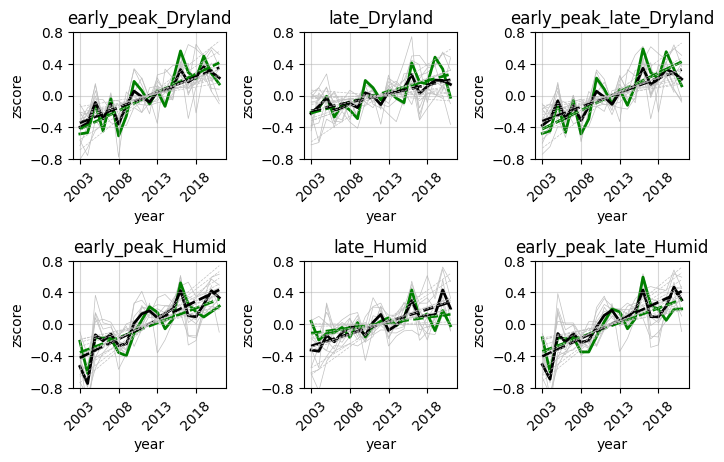

In [40]:
Stabilization_amplification_longterm_trends().plot_time_series_zscore()

In [41]:
Stabilization_amplification_longterm_trends().calculate_stabilization_temporal_change_statistic()

100%|██████████████████████| 333260/333260 [00:12<00:00, 27604.20it/s]
loading Data//Base_data/aridity_P_PET_dic/: 100%|█| 26/26 [00:00<00:00
100%|██████████████████████| 332532/332532 [00:11<00:00, 27764.31it/s]
loading Data//Base_data/aridity_P_PET_dic/: 100%|█| 26/26 [00:01<00:00
100%|██████████████████████| 310284/310284 [00:11<00:00, 27715.73it/s]
loading Data//Base_data/aridity_P_PET_dic/: 100%|█| 26/26 [00:01<00:00
100%|██████████████████████| 357770/357770 [00:12<00:00, 27552.31it/s]
loading Data//Base_data/aridity_P_PET_dic/: 100%|█| 26/26 [00:01<00:00
100%|██████████████████████| 302233/302233 [00:10<00:00, 27685.47it/s]
loading Data//Base_data/aridity_P_PET_dic/: 100%|█| 26/26 [00:01<00:00
100%|██████████████████████| 337915/337915 [00:12<00:00, 27602.89it/s]
loading Data//Base_data/aridity_P_PET_dic/: 100%|█| 26/26 [00:00<00:00
100%|██████████████████████| 356079/356079 [00:12<00:00, 27601.04it/s]
loading Data//Base_data/aridity_P_PET_dic/: 100%|█| 26/26 [00:01<00:00
100%|█

                      model     a_amp  a_strong_stab  a_weak_stab  \
0  Dryland-CABLE-POP_S2_lai  0.004521      -0.011812     0.007291   
1    Humid-CABLE-POP_S2_lai  0.000497      -0.004278     0.003782   
2    Dryland-CLASSIC_S2_lai -0.008289       0.001830     0.006460   
3      Humid-CLASSIC_S2_lai -0.007267      -0.002264     0.009531   
4              Dryland-CLM5 -0.015840       0.001511     0.014329   
5                Humid-CLM5 -0.020439       0.006160     0.014279   
6       Dryland-DLEM_S2_lai -0.005598      -0.003995     0.009593   
7         Humid-DLEM_S2_lai -0.002577      -0.000985     0.003563   
8       Dryland-IBIS_S2_lai -0.000533      -0.003705     0.004238   
9         Humid-IBIS_S2_lai -0.000818      -0.007373     0.008191   

          p_amp  p_strong_stab   p_weak_stab  
0  8.099261e-02       0.003472  3.688578e-03  
1  7.909881e-01       0.078169  3.247853e-02  
2  2.163543e-02       0.415503  4.459968e-02  
3  3.986018e-02       0.391369  9.316750e-04  
4  8.

In [42]:
Stabilization_amplification_longterm_trends().zscore_vs_stabilization_composition()

100%|█████████████████████████████████████████| 22/22 [00:00<?, ?it/s]

['Humid-MCD', 'Humid-CABLE-POP_S2_lai', 'Humid-CLASSIC_S2_lai', 'Humid-CLM5', 'Humid-IBIS_S2_lai', 'Humid-ISAM_S2_LAI', 'Humid-ISBA-CTRIP_S2_lai', 'Humid-JSBACH_S2_lai', 'Humid-LPX-Bern_S2_lai', 'Humid-VISIT_S2_lai', 'Humid-YIBs_S2_Monthly_lai', 'Dryland-MCD', 'Dryland-CABLE-POP_S2_lai', 'Dryland-CLASSIC_S2_lai', 'Dryland-CLM5', 'Dryland-IBIS_S2_lai', 'Dryland-ISAM_S2_LAI', 'Dryland-ISBA-CTRIP_S2_lai', 'Dryland-JSBACH_S2_lai', 'Dryland-LPX-Bern_S2_lai', 'Dryland-VISIT_S2_lai', 'Dryland-YIBs_S2_Monthly_lai']
                     model  k_value_early_peak  k_value_early_peak_late  \
0                Humid-MCD            0.037234                 0.036299   
1   Humid-CABLE-POP_S2_lai            0.041812                 0.041915   
2     Humid-CLASSIC_S2_lai            0.033093                 0.031333   
3               Humid-CLM5            0.053392                 0.050234   
4        Humid-IBIS_S2_lai            0.081831                 0.079581   
5        Humid-ISAM_S2_LAI           

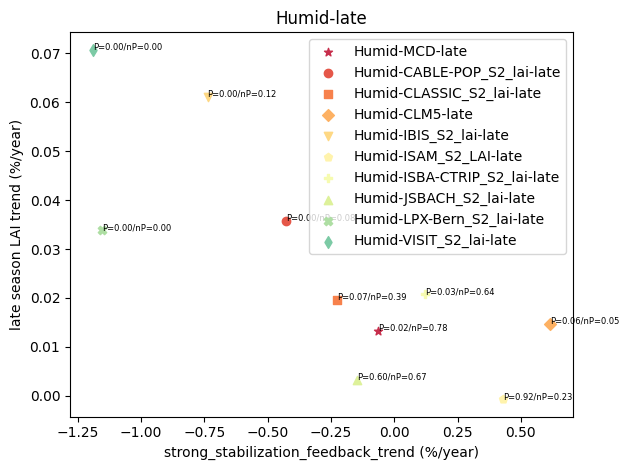

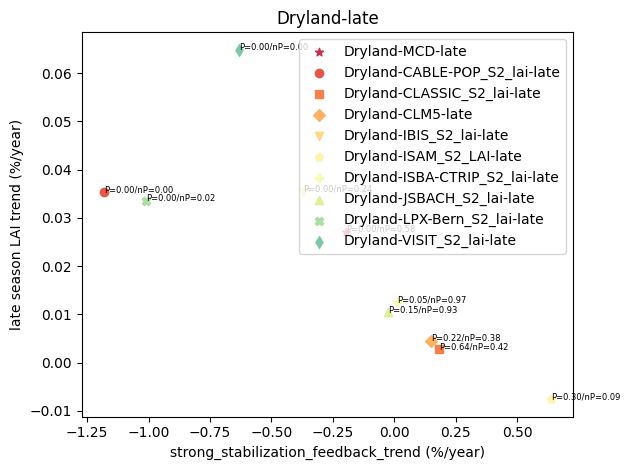

In [43]:
Stabilization_amplification_longterm_trends().plot_feedback_vs_trend()